In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import pandas as pd
from tqdm import tqdm

## Universal Givens

In [2]:
# Givens
gamma = 24 # kN/m^3

# Geometric Givens
l = 18/3.28084 # m
num_points = 1001
num_segments = num_points-1
x = np.linspace(0,l,num_points) # Slices along length

# Concrete Givens
fc = 60 # MPa
Ec = 4500*np.sqrt(fc)
fci = 0.65*fc # Mpa
fr = 0.6*np.sqrt(fc)
ft = 0.33*np.sqrt(fc)
e_cu = -0.0035
e_c = -0.002
A_RO = 0.025
B_RO = 118
C_RO = 10
ag = 10 # mm (Coarse Aggregate Size)

# Prestressed Tendon Givens
fpu = 1860 # MPa
fpo = 0.75*fpu # MPa
fpi = 0.7*fpu # MPa
A_per_strand = 98.8 # mm^2 (9mm strand)
fpy = 0.9*fpu # MPa
Ep = 200000 # MPa
diam_tendon = 13 #mm

# Mild Steel Givens
fy = 400 # mm^2
Es = 200000 # MPa
A_per_bar = 300 # mm^2 (20M bar)

print(f'fci: {fci:1.2f} MPa')
print(f'fr: {fr:1.2f} MPa')
print(f'ft: {ft:1.2f} MPa')
print(f'Ec: {Ec:1.1f} MPa')

fci: 39.00 MPa
fr: 4.65 MPa
ft: 2.56 MPa
Ec: 34856.9 MPa


## Applied Point Loads

In [3]:
PL_serv = [44.5,44.5] # kN
PL_ult = [71,71] # kN
PL_loc = [12/3.28084,15/3.28084] # m

## T-Shape Definition

### Design Specifications

In [4]:
# Iterating Concrete Parameters
fw = 245 # mm (Flange Width)
fd = 150 # mm (Flange Depth)
wd = 275 # mm (Web Depth)
bw = 125 # mm (Web Width)

# Iterationg Prestressed Tendon Parameters
n_strands = 3
e = 125 # mm (Eccentricity at max moment location)

# Iterating Top Steel Parameters
n_bars = 2
dist_from_top = 75 # mm

### Geometric Calculations

In [5]:
h = fd + wd # mm

# Areas
flange_area = fw*fd # mm^2
web_area = wd*bw # mm^2
Ag = flange_area + web_area # mm^2
Ap = n_strands*A_per_strand # mm^2
As = n_bars*A_per_bar # mm^2
Ac = Ag - Ap - As # mm^2

# Y-bars
y_g_bot = (wd*bw*(wd/2) + fw*fd*(wd+fd/2))/(wd*bw+fw*fd)
y_g_top = h-y_g_bot
y_p_top_max = y_g_top + e
y_p_bot_max = h - y_p_top_max
y_s_top = dist_from_top
y_s_bot = h - y_s_top

# Moment Of Inertia
Ig = (1/12*fw*fd**3 + flange_area*(y_g_top-fd/2)**2+
      1/12*bw*wd**3 + web_area*(y_g_bot-wd/2)**2)


print(f'Ag:{Ag: 1.1f} mm^2')
print(f'Ap:{Ap: 1.1f} mm^2')
print(f'As\':{As: 1.1f} mm^2')
print(f'Ac:{Ac: 1.1f} mm^2')
print(f'Ig:{Ig: 1.1f} mm^4')
print(f'y_bar of gross section about bottom: {y_g_bot:1.2f} mm')
print(f'y_bar of tendon about bottom (harping point): {y_p_bot_max:1.2f} mm')
print(f'y_bar of top steel about bottom: {y_s_bot:1.0f} mm')
print(f'y_bar of gross section about top: {y_g_top:1.2f} mm')
print(f'y_bar of tendon about top (harping point): {y_p_top_max:1.2f} mm')
print(f'y_bar of top steel about top: {y_s_top:1.0f} mm')

Ag: 71125.0 mm^2
Ap: 296.4 mm^2
As': 600.0 mm^2
Ac: 70228.6 mm^2
Ig: 1087579646.8 mm^4
y_bar of gross section about bottom: 247.30 mm
y_bar of tendon about bottom (harping point): 122.30 mm
y_bar of top steel about bottom: 350 mm
y_bar of gross section about top: 177.70 mm
y_bar of tendon about top (harping point): 302.70 mm
y_bar of top steel about top: 75 mm


We've decided to use a singly-harped tendon layout, with the eccentricity at the ends being zero and the eccentricity at the location of the first point load from the left (anticipated location of maximum moment).

Placing the harp at PL location, the tendon layout will appear as below (e is variable):

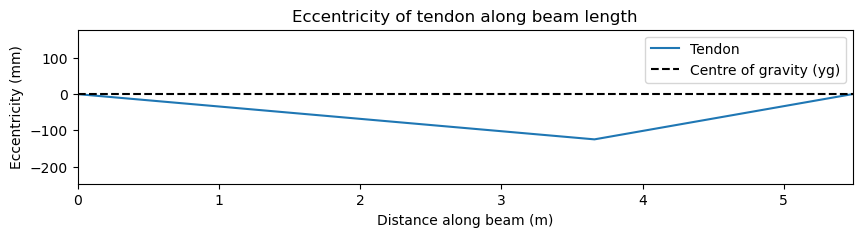

In [6]:
eccentricity = np.zeros(len(x)) # mm
tendon_angle = np.zeros(len(x)) # radians
tendon_angle_ls = e/(PL_loc[0]*1000)
tendon_angle_rs = e/((l-PL_loc[0])*1000)

for i in range(len(x)):
    if x[i] <= PL_loc[0]:
        eccentricity[i]=e/PL_loc[0]*x[i]
        tendon_angle[i]=tendon_angle_ls
    elif x[i]>PL_loc[0]:
        eccentricity[i]=e/(l-PL_loc[0])*(l-x[i])
        tendon_angle[i]=tendon_angle_rs

y_p_top = y_g_top+eccentricity
y_p_bot = 1-y_p_top
plt.figure(figsize=(10,2))
plt.plot(x,-eccentricity,label='Tendon')
plt.plot(x,np.zeros(len(x)),'k--',label='Centre of gravity (yg)')
plt.xlabel('Distance along beam (m)')
plt.ylabel('Eccentricity (mm)')
plt.title('Eccentricity of tendon along beam length')
plt.xlim(0,l)
plt.ylim(-y_g_bot,y_g_top)
plt.legend()

We want to use three tendons. Can they all fit on one layer?

- Since tested after one month, exposure class N assumed. For class N, cover requirement = 30mm (CSA A23-19 Table 17)
- From A23-19 CL 7.4.3, c-c spacing of 45mm OK since fci is greater than 27.5 MPA

If in same layer:

In [7]:
cover = 30
spacing = 45
w_reqd_3perlayer = 2*cover+2*spacing+diam_tendon
w_reqd_2perlayer = 2*cover+1*spacing+diam_tendon
print(f'Width required:{w_reqd_2perlayer:1.3f} mm')
print(f'Width required:{w_reqd_3perlayer:1.3f} mm')

Width required:118.000 mm
Width required:163.000 mm


Evidently, all three cannot fit into one layer. Make bottom layer have two tendons and top layer having one. Calculate d_top_layer1 and d_bot_layer2 such that eccentricity is maintained.

In [8]:
yp_ref = max(y_p_top)

def find_top(d_top_layer1):
    y_lay1 = d_top_layer1
    y_lay2 = d_top_layer1 + spacing
    y_bar = (1*y_lay1 + 2*y_lay2)/(1+2)
    return y_bar-yp_ref

d_top_layer1 = brentq(find_top,1,800)
d_top_layer2 = d_top_layer1 + spacing

In [9]:
print(f'd top layer: {d_top_layer1:1.2f}mm')
print(f'd bott layer: {d_top_layer2:1.2f}mm')

d top layer: 272.58mm
d bott layer: 317.58mm


### Transformed Section Properties

Due to harped tendon, I_tr and y_tr vary across the cross-section. See the calculations below for which $I_{tr}$ was determined

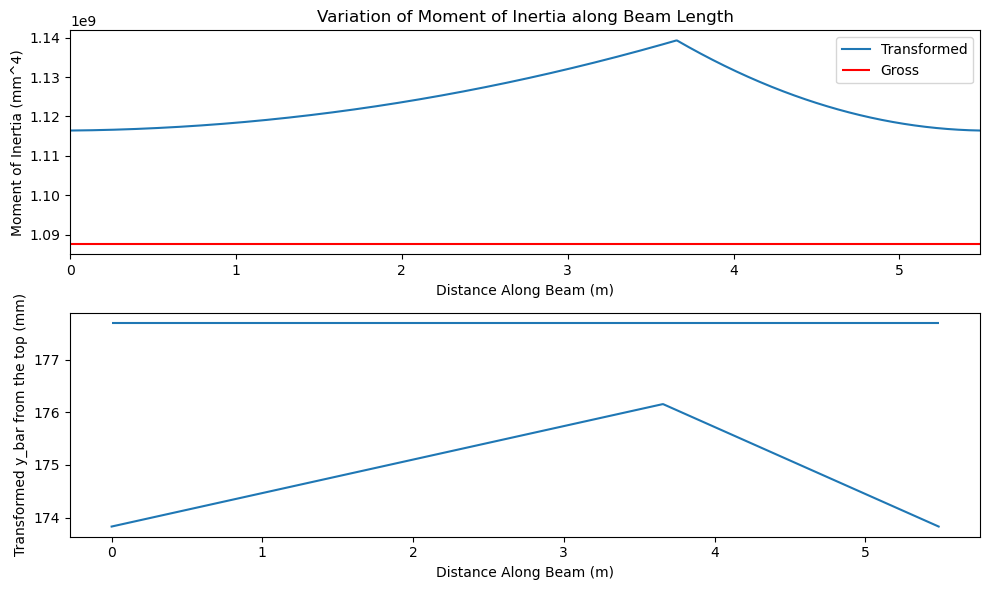

In [10]:
n_s = Es/Ec
n_p = Ep/Ec
Ap_tr = n_p*Ap # mm^2
As_tr = n_s*As # mm^2

A_tr = Ac + As_tr + Ap_tr # mm^2
y_tr_top = (Ag*y_g_top + (n_s-1)*(As*y_s_top)+(n_p-1)*(Ap*y_p_top))/A_tr
y_tr_bot = h-y_tr_top

I_tr = (Ig + Ag*(y_g_top-y_tr_top)**2 + (n_s-1)*As*(y_s_top-y_tr_top)**2
       + (n_p-1)*Ap*(y_p_top-y_tr_top)**2)

fig, ax = plt.subplots(2,1,figsize=[10,6])
ax[0].plot(x,I_tr,label='Transformed')
ax[0].hlines(Ig,x[0],x[-1],label='Gross',color='r')
ax[0].set_xlabel('Distance Along Beam (m)')
ax[0].set_ylabel('Moment of Inertia (mm^4)')
ax[0].set_xlim(0,l)
ax[0].set_title('Variation of Moment of Inertia along Beam Length')
ax[0].legend()
ax[1].plot(x,y_tr_top,label='y_tr')
ax[1].hlines(y_g_top,0,l)
ax[1].set_xlabel('Distance Along Beam (m)')
ax[1].set_ylabel('Transformed y_bar from the top (mm)')
plt.tight_layout()

### Self-Weight Calculation

In [11]:
w = Ag*gamma*(1/1000)**2 # kN/m (Self-weight UDL)

print(f'Self Weight UDL = {w:1.3f} kN/m')

Self Weight UDL = 1.707 kN/m


## Bending Moment Diagram & Shear Diagram

In [12]:
M_pl_serv = np.zeros(len(x))
M_pl_ult = np.zeros(len(x))
V_pl_serv = np.zeros(len(x))
V_pl_ult = np.zeros(len(x))
for i in range(len(PL_serv)):
    a = PL_loc[i]
    b = l-a
    for j in range(len(x)):
        if x[j]<=PL_loc[i]:        
            M_pl_serv[j]+=PL_serv[i]*b*x[j]/l
            M_pl_ult[j]+=PL_ult[i]*b*x[j]/l
            V_pl_serv[j]+=PL_serv[i]*b/l
            V_pl_ult[j]+=PL_ult[i]*b/l
        elif x[j]>PL_loc[i]:
            M_pl_serv[j]+=PL_serv[i]*a*(l-x[j])/l
            M_pl_ult[j]+=PL_ult[i]*a*(l-x[j])/l
            V_pl_serv[j]+=PL_serv[i]*(b/l-1)
            V_pl_ult[j]+=PL_ult[i]*(b/l-1)          
M_sw = w*x/2*(l-x) # kNm
V_sw = w*(l/2-x) # kN
M_serv = M_pl_serv + M_sw # kNm
M_ult = M_pl_ult + M_sw # kNm
V_serv = V_pl_serv + V_sw # kN
V_ult = V_pl_ult + V_sw # kN

M_serv_max = max(M_serv) # kNm
M_ult_max = max(M_ult) # kNm
V_serv_max = max(V_serv) # kN
V_ult_max = max(V_ult) # kN
V_serv_min = min(V_serv) # kN
V_ult_min = min(V_ult) # kN

ind = np.where(M_serv==M_serv_max)
Mmax_loc = x[ind][0]

(-111.18264225015545, 40.18264225015545)

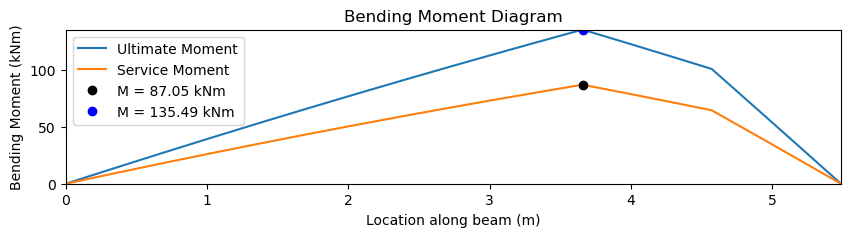

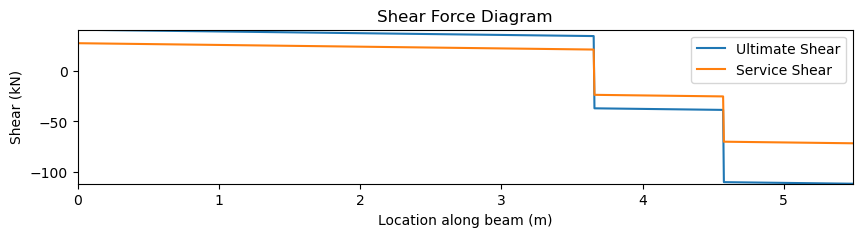

In [13]:
fig,ax = plt.subplots(figsize=(10,2))
ax.plot(x,M_ult,label="Ultimate Moment")
ax.plot(x,M_serv,label="Service Moment")
ax.plot(Mmax_loc,M_serv_max,'ko',label=f'M = {M_serv_max:1.2f} kNm')
ax.plot(Mmax_loc,M_ult_max,'bo',label=f'M = {M_ult_max:1.2f} kNm')

ax.legend()
ax.set_xlabel('Location along beam (m)')
ax.set_ylabel('Bending Moment (kNm)')
ax.set_title('Bending Moment Diagram')
ax.set_xlim(0,l)
ax.set_ylim(0,M_ult_max)

fig,ax = plt.subplots(figsize=(10,2))
ax.plot(x,V_ult,label="Ultimate Shear")
ax.plot(x,V_serv,label="Service Shear")
ax.legend()
ax.set_xlabel('Location along beam (m)')
ax.set_ylabel('Shear (kN)')
ax.set_title('Shear Force Diagram')
ax.set_xlim(0,l)
ax.set_ylim(V_ult_min,V_ult_max)

## Fibre Stress Checks

Since the beam is being tested one month after casting, it is assumed that long-term losses are negligible. Assumptions noted are as follows:

- Jacking stress $fpo=0.75\times fpu=1395$ MPa
- Prestress-transfer (short-term stress) $fpi=0.7\times fpu=1302$ MPa

In [14]:
P_i = fpi*Ap # N
f_ct_transfer = -P_i/Ag + P_i*eccentricity*y_g_top/Ig - M_sw*1000**2*y_g_top/Ig
f_cb_transfer = -P_i/Ag - P_i*eccentricity*y_g_bot/Ig + M_sw*1000**2*y_g_bot/Ig
f_ct_serv = -P_i/Ag + P_i*eccentricity*y_g_top/Ig - M_serv*1000**2*y_g_top/Ig
f_cb_serv = -P_i/Ag - P_i*eccentricity*y_g_bot/Ig + M_serv*1000**2*y_g_bot/Ig

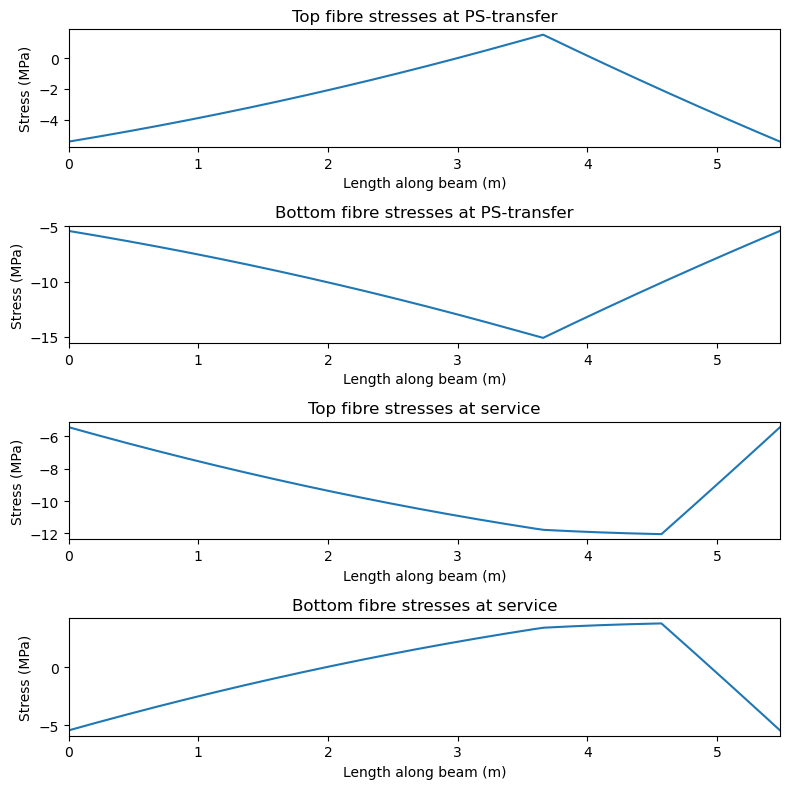

In [15]:
fig, ax = plt.subplots(4,1,figsize=[8,8])
ax[0].plot(x,f_ct_transfer)
ax[1].plot(x,f_cb_transfer)
ax[2].plot(x,f_ct_serv)
ax[3].plot(x,f_cb_serv)

titles = ['Top fibre stresses at PS-transfer', 'Bottom fibre stresses at PS-transfer',
         'Top fibre stresses at service','Bottom fibre stresses at service']

for i in range(4):
    ax[i].set_xlabel('Length along beam (m)')
    ax[i].set_ylabel('Stress (MPa)')
    ax[i].set_title(titles[i])
    ax[i].set_xlim(0,l)

plt.tight_layout()

### Initial Stage Checks

In [16]:
comp_fibre_stress_lim = -0.6*fci
tens_fibre_stress_lim = 0.25*np.sqrt(fci)
comp_fibre_stress = min(f_cb_transfer)
tens_fibre_stress = max(f_ct_transfer)

if comp_fibre_stress>comp_fibre_stress_lim:
    print(f'OK! Compressive Fibre Stress: {comp_fibre_stress:1.2f} MPa > limit: {comp_fibre_stress_lim:1.2f} MPa')
else:
    print(f'Fail! Compressive Fibre Stress: {comp_fibre_stress:1.2f} MPa < limit: {comp_fibre_stress_lim:1.2f} MPa')

if tens_fibre_stress<tens_fibre_stress_lim:
    print(f'OK! Tensile Fibre Stress: {tens_fibre_stress:1.2f} MPa < limit: {tens_fibre_stress_lim:1.2f} MPa')
else:
    print(f'Fail! Tensile Fibre Stress: {tens_fibre_stress:1.2f} MPa > limit: {tens_fibre_stress_lim:1.2f} MPa')


OK! Compressive Fibre Stress: -15.09 MPa > limit: -23.40 MPa
OK! Tensile Fibre Stress: 1.52 MPa < limit: 1.56 MPa


### Service Stage Checks

In [17]:
comp_fibre_stress_lim = -0.6*fc
tens_fibre_stress_lim = 0.5*np.sqrt(fc)
comp_fibre_stress = min(f_ct_serv)
tens_fibre_stress = max(f_cb_serv)

if comp_fibre_stress>comp_fibre_stress_lim:
    print(f'OK! Compressive Fibre Stress: {comp_fibre_stress:1.2f} MPa > limit: {comp_fibre_stress_lim:1.2f} MPa')
else:
    print(f'Fail! Compressive Fibre Stress: {comp_fibre_stress:1.2f} MPa < limit: {comp_fibre_stress_lim:1.2f} MPa')

if tens_fibre_stress<tens_fibre_stress_lim:
    print(f'OK! Tensile Fibre Stress: {tens_fibre_stress:1.2f} MPa < limit: {tens_fibre_stress_lim:1.2f} MPa')
else:
    print(f'Fail! Tensile Fibre Stress: {tens_fibre_stress:1.2f} MPa > limit: {tens_fibre_stress_lim:1.2f} MPa')


OK! Compressive Fibre Stress: -12.04 MPa > limit: -36.00 MPa
OK! Tensile Fibre Stress: 3.78 MPa < limit: 3.87 MPa


## Cracking Moment

Text(0.5, 1.0, 'Decompression moment along beam length')

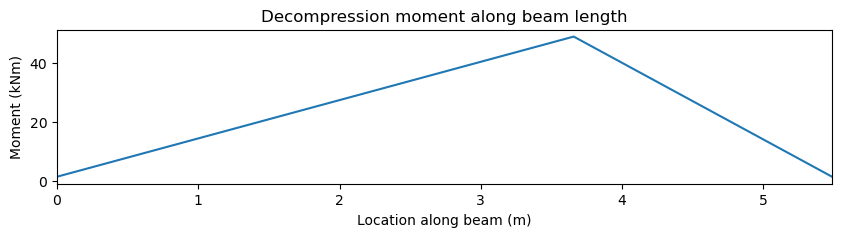

In [18]:
# Decompression Forces
N = 0
N_0 = Ap*fpi # N
M_0 = N_0 * (eccentricity+y_g_top-y_tr_top) * 1/1000**2 # kNm
plt.figure(figsize=(10,2))
plt.plot(x,M_0)
plt.xlim(0,l)
plt.xlabel('Location along beam (m)')
plt.ylabel('Moment (kNm)')
plt.title('Decompression moment along beam length')

Cracking Moment at maximum eccentricity location: 93.51 kNm


Text(0.5, 1.0, 'Moment to crack beam along length of beam')

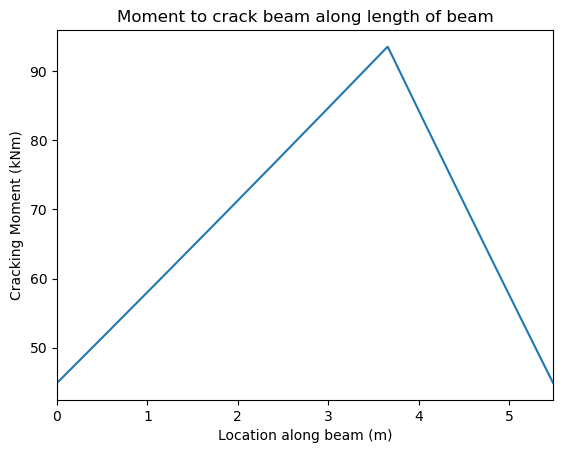

In [19]:
e_cog = (N - N_0)/(Ec*A_tr)
f_cog = e_cog*Ec
M_cr = (fr-f_cog)*I_tr/(y_tr_bot)/1000**2 + M_0
crit_M_cr = max(M_cr)
print(f'Cracking Moment at maximum eccentricity location: {crit_M_cr:1.2f} kNm')
plt.plot(x,M_cr)
plt.xlim(0,l)
plt.xlabel('Location along beam (m)')
plt.ylabel('Cracking Moment (kNm)')
plt.title('Moment to crack beam along length of beam')

(0.0, 93.50703453591052)

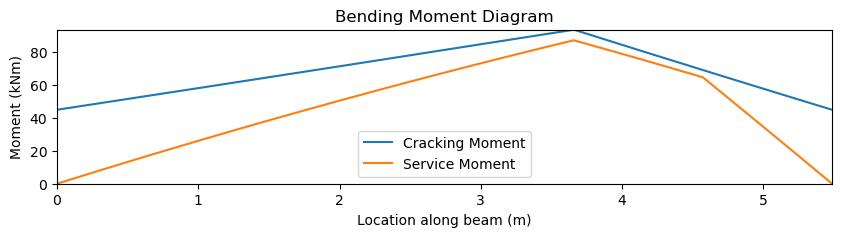

In [20]:
fig,ax = plt.subplots(figsize=(10,2))
ax.plot(x,M_cr,label="Cracking Moment")
ax.plot(x,M_serv,label="Service Moment")
ax.legend()
ax.set_xlabel('Location along beam (m)')
ax.set_ylabel('Moment (kNm)')
ax.set_title('Bending Moment Diagram')
ax.set_xlim(0,l)
ax.set_ylim(0,max(M_cr))

In [21]:
ut_r = max(M_serv/M_cr)
print(ut_r)

0.9367081126152034


## Ultimate Moment

In [46]:
alpha = 0.85-0.0015*fc
beta = 0.97-0.0025*fc
del_ep = fpi/Ep

def RambergOsgood(e_p):
    fp = Ep*e_p*(A_RO+(1-A_RO)/(1+(B_RO*e_p)**C_RO)**(1/C_RO))
    return fp

def f(c):
    ep = e_cu*(c-yptop)/c+del_ep
    es = e_cu*(c-y_s_top)/c
    fs = es*Es
    if fs<-fy:
        fs=-fy
    fp = RambergOsgood(ep)
    Tp = fp*Ap
    Cs = fs*As
    Cc = -(alpha*fc)*(beta*c)*fw
    C = Cc + Cs
    return Tp+C

Mr = np.zeros(num_points)
for i in range(num_points):
    yptop = y_p_top[i]
    c = brentq(f,1,800)
    ep = e_cu*(c-yptop)/c+del_ep
    fp = RambergOsgood(ep)
    Tp = fp*Ap
    Mr[i] = Tp*(yptop-beta*c/2)/1000**2

In [47]:
print(alpha,beta)

0.76 0.82


(0.0, 143.27337679931472)

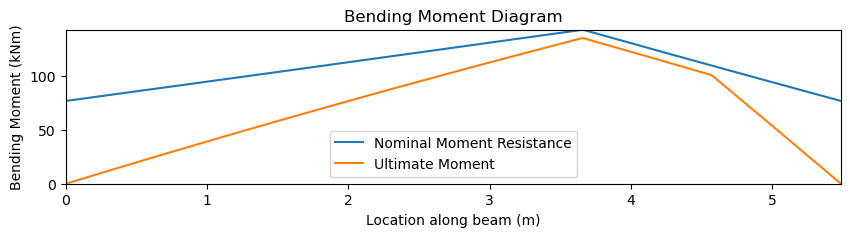

In [24]:
fig,ax = plt.subplots(figsize=(10,2))
ax.plot(x,Mr,label="Nominal Moment Resistance")
ax.plot(x,M_ult,label="Ultimate Moment")
ax.legend()
ax.set_xlabel('Location along beam (m)')
ax.set_ylabel('Bending Moment (kNm)')
ax.set_title('Bending Moment Diagram')
ax.set_xlim(0,l)
ax.set_ylim(0,max(Mr))

In [25]:
ut_r = max(M_ult/Mr)
print(ut_r)

0.9456473793617474


## Ultimate Shear

Text(0, 0.5, 'dv (mm)')

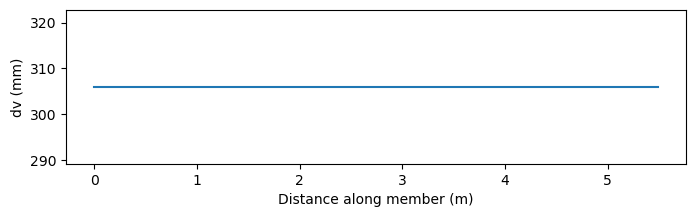

In [26]:
dv = np.zeros(len(x))
for i in range(len(x)):
    dv[i] = max(0.9*y_p_top[i],0.72*h) #mm
fig, ax = plt.subplots(figsize=[8,2])
ax.plot(x,dv)
ax.set_xlabel('Distance along member (m)')
ax.set_ylabel('dv (mm)')

Since it is evident from the above that 0.72h always governs, dv not need be an array but rather a scalar.

In [27]:
dv = 0.72*h # mm
print(f'dv: {dv:1.2f} mm')

dv: 306.00 mm


In [28]:
#def find_s(s):
#    Vs = Av*fy*dv/(np.tan(np.deg2rad(t))*s)
#    Vc = b*np.sqrt(fc)*bw*dv
#    Vp = P_i*alpha
#    Vr = Vs + Vc
#    return abs()

Act = h/2*bw #mm^2
Vp = P_i*tendon_angle/1000 #kN
ex = np.zeros(len(x))

for i in range(len(x)):
    ex[i] = (M_ult[i]*1000**2/dv+(V_ult[i]-Vp[i])*1000 - Ap*fpi)/(2*Ep*Ap)
    if ex[i]<0:
        ex[i] = ((M_ult[i]*1000**2/dv+(V_ult[i]-Vp[i])*1000
                  - Ap*fpi)/(2*Ep*Ap+2*Ec*Act))
        
theta = 29 + 7000*ex

# Determination of beta
sz = dv # Conservative
sze = 35*sz/(15+ag)
beta = 0.4/(1+1500*ex) * 1300/(1000+sze)
Vc = beta*np.sqrt(fc)*bw*dv/1000 # kN
Vr = Vc + Vp

col_names = ['x (m)', 'V_ult (kN)', 'M_ult (kNm)', 'ex', 'beta','theta', 'Vc (kN)','Vp (kN)', 'Vr (kN)']
table = pd.DataFrame(list(zip(x,V_ult,M_ult,ex,beta,theta,Vc,Vp,Vr)),columns=col_names)
print(f'sze: {sze:1.2f} mm')
print(table)

sze: 428.40 mm
         x (m)  V_ult (kN)  M_ult (kNm)        ex      beta      theta  \
0     0.000000   40.182642     0.000000 -0.000182  0.500915  27.724867   
1     0.005486   40.173277     0.220432 -0.000182  0.500542  27.727393   
2     0.010973   40.163912     0.440813 -0.000181  0.500170  27.729919   
3     0.016459   40.154546     0.661143 -0.000181  0.499799  27.732444   
4     0.021946   40.145181     0.881421 -0.000181  0.499428  27.734968   
...        ...         ...          ...       ...       ...        ...   
996   5.464454 -111.145181     2.439559 -0.000262  0.599169  27.168712   
997   5.469941 -111.154546     1.829746 -0.000263  0.600676  27.161599   
998   5.475427 -111.163912     1.219882 -0.000264  0.602190  27.154485   
999   5.480913 -111.173277     0.609967 -0.000265  0.603713  27.147371   
1000  5.486400 -111.182642     0.000000 -0.000266  0.605243  27.140256   

         Vc (kN)    Vp (kN)     Vr (kN)  
0     148.412733  13.188731  161.601464  
1     148.30

Text(0, 0.5, 'Shear (kN)')

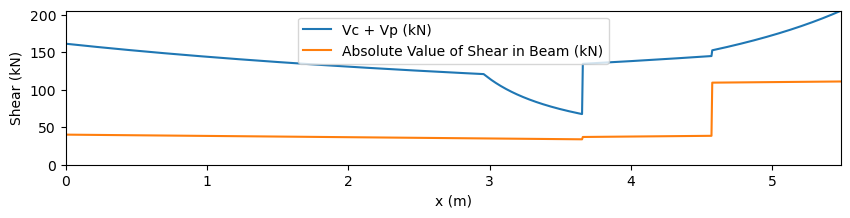

In [29]:
plt.figure(figsize=(10,2))
plt.plot(x,Vr,label='Vc + Vp (kN)')
plt.plot(x,abs(V_ult),label='Absolute Value of Shear in Beam (kN)')
plt.legend()
plt.ylim(0,max(Vr))
plt.xlim(0,l)
plt.xlabel('x (m)')
plt.ylabel('Shear (kN)')

Since the shear resistance of combined prestressing and concrete is consistently greater than the factored shear in the beam, OK without stirrups!

However, still need to check crushing limit:

In [30]:
Vr_max = 0.25*fc*bw*dv/1000
print(f'Crushing Limit: {Vr_max:1.2f} (kN)')

Crushing Limit: 573.75 (kN)


Vf-Vp never exceeds crushing limit. OK!

Also need to check longitudinal proportion limit!

Text(0, 0.5, 'F_lt')

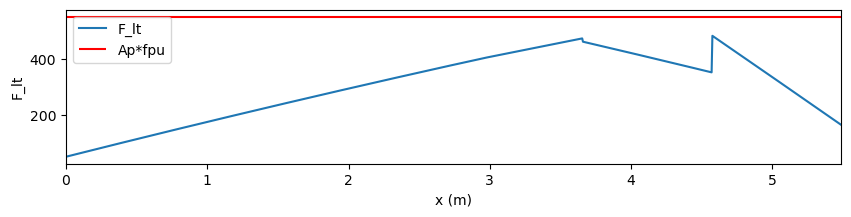

In [31]:
F_lt = M_ult/(dv/1000)+(abs(V_ult)-Vp)/np.tan(np.deg2rad(theta))
plt.figure(figsize=(10,2))
plt.plot(x,F_lt,label='F_lt')
plt.hlines(Ap*fpu/1000,0,l,colors='r',label='Ap*fpu')
plt.xlim(0,l)
plt.legend()
plt.xlabel('x (m)')
plt.ylabel('F_lt')

Since tension-zone reinforcement force > F_lt, OK!

## Deflections

### Service Loads (No Cracking)

In [32]:
phi_service = (M_serv-M_0)*1000**2/(Ec*I_tr) # Precrack
seg_width = (l/num_segments)*1000 # mm

# Finding Trapezoidal Centroids and Areas
centroids = np.zeros(num_segments)
trap_area = np.zeros(num_segments)
for i in range(num_segments):
    centroids[i]=x[i]*1000+(seg_width*(2*M_serv[i]+M_serv[i+1])/(3*(M_serv[i]+M_serv[i+1])))
    trap_area[i]=seg_width*(max(phi_service[i],phi_service[i+1])-abs(phi_service[i]-phi_service[i+1])/2)
    
centroids = np.append(0,centroids)
trap_area = np.append(0,trap_area)

Text(0.5, 1.0, 'Phi Along Beam')

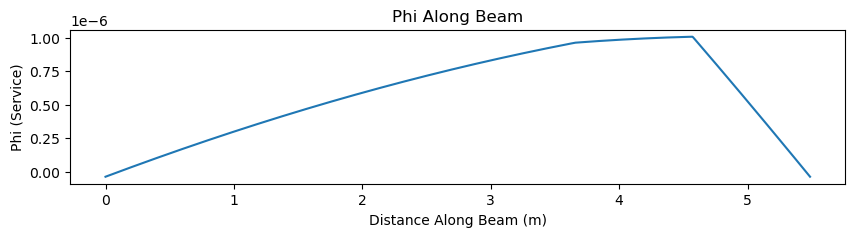

In [33]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(x,phi_service)
ax.set_xlabel('Distance Along Beam (m)')
ax.set_ylabel('Phi (Service)')
ax.set_title('Phi Along Beam')

In [34]:
t_ba = np.zeros(len(x))

for i in tqdm(range(len(x)),desc='Progress'):
    for j in range(len(centroids)):
        if centroids[j]<x[i]*1000:
            t_ba[i]+=(x[i]*1000-centroids[j])*trap_area[j]

Progress: 100%|███████████████████████████| 1001/1001 [00:00<00:00, 1838.33it/s]


In [35]:
slope_ls = np.sum(trap_area*(l*1000-centroids))/(l*1000)
deflec = slope_ls*x*1000-t_ba

(-2.7007325332194707, 0.0)

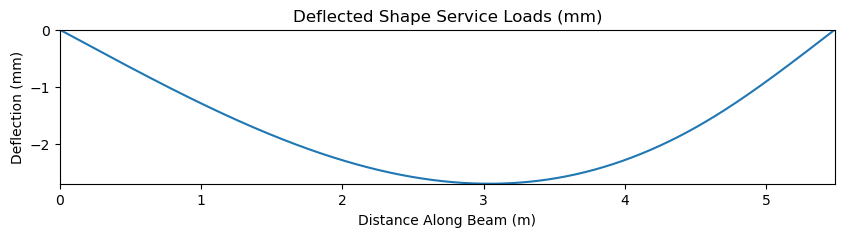

In [36]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(x,-deflec)
ax.set_xlabel('Distance Along Beam (m)')
ax.set_ylabel('Deflection (mm)')
ax.set_title('Deflected Shape Service Loads (mm)')
ax.set_xlim(0,l)
ax.set_ylim(-max(deflec),0)

In [37]:
index = np.where(deflec==max(deflec))
x[index]

array([3.0394655])

### Ultimate Loads (With Cracking)

The challenge here is that the moment-curvature response changes everywhere that the tendon drape changes. Thus, to find the curvature at each segment, the moment-curvature response needs to be determined at each segment.

In [38]:
e_cc = np.linspace(-0.0002,e_cu,num_points)
B = (4-e_cc/e_c)/(6-2*(e_cc-e_c))
a = 1/B*(e_cc/e_c-(e_cc/e_c)**2/3)

In [39]:
phi_ult = np.zeros(num_points)
for i in tqdm(range(num_points),desc='Progress'):
    Mf = M_ult[i]
    M_crack = M_cr[i]
    if Mf<M_crack:
        phi_ult[i] = (Mf-M_0[i])*1000**2/(Ec*I_tr[i])
    if Mf>M_crack:
        M = np.zeros(len(e_cc))
        phi = np.zeros(len(e_cc))
        for j in range(len(e_cc)):
            e_conc = e_cc[j]
            Alpha = a[j]
            Beta = B[j]
            def function3(c):
                e_p = e_conc*(c-y_p_top[i])/c + del_ep
                e_c_bot = e_conc*(c-y_p_top[i])/c
                e_s = e_conc*(c-y_s_top)/c
                f_p = RambergOsgood(e_p)
                f_c_bot = e_c_bot*Ec
                f_s = e_s*Es
                
                # Stress Limits
                Ac_eff = (7.5*diam_tendon*2+spacing)*bw
                if f_c_bot>ft:
                    pp = Ap/Ac_eff
                    alpha_1 = 0.7 # Tendons only
                    alpha_2 = 1 # Short-term load
                    fc1 = alpha_1*alpha_2*ft/(1+np.sqrt(500*e_c_bot))
                    fc2 = pp*(fpy-f_p)
                    f_c_bot = max(min(fc1,fc2),0)
                if f_p > fpy:
                    f_p = fpy
                if f_s<-fy:
                    f_s=-fy
                
                # Forces
                if c<fd:
                    Cc = -(Alpha*fc)*(Beta*c)*fw
                else:
                    Cc = -(Alpha*fc)*(fd*fw+(Beta*c-fd)*bw)
                Cs = f_s*As
                C = Cs + Cc
                Tc = Ac_eff*f_c_bot
                Tp = Ap*f_p
                T = Tc + Tp
                return T+C
            
            c = brentq(function3,1,800)
            ep = e_conc*(c-y_p_top[i])/c+del_ep
            ec_bot = e_conc*(c-y_p_top[i])/c
            es_top = e_conc*(c-y_s_top)/c
            
            fs_top = es_top*Es
            if fs_top<-fy:
                fs_top=-fy
            Cs = fs_top*As/1000 # kN
            
            fp = RambergOsgood(ep)
            if fp>fpy:
                fp = fpy
            Tp = fp*Ap/1000 # kN
                
            fc_bot = ec_bot*Ec
            Ac_eff = (7.5*diam_tendon*2+spacing)*bw
            if fc_bot>ft:
                    pp = Ap/Ac_eff
                    alpha_1 = 0.7 # Tendons only
                    alpha_2 = 1 # Short-term load
                    fc1 = alpha_1*alpha_2*ft/(1+np.sqrt(500*ec_bot))
                    fc2 = pp*(fpy-fp)
                    fc_bot = max(min(fc1,fc2),0)
            Tc = fc_bot*Ac_eff/1000 # kN
            
            if c<fd:
                Cc = -(Alpha*fc)*(Beta*c)*fw/1000 # kN
            else:
                Cc = -(Alpha*fc)*(fd*fw+(Beta*c-fd)*bw)/1000 # kN
            M[j] = (Cc*(Beta*c/2)+Cs*y_s_top+(Tp+Tc)*(y_p_top[i]))/1000
            phi[j]=-e_conc/c
        phi_ult[i] = np.interp(Mf,M,phi)

Progress: 100%|█████████████████████████████| 1001/1001 [00:32<00:00, 30.34it/s]


Text(0.5, 1.0, 'Phi Along Beam')

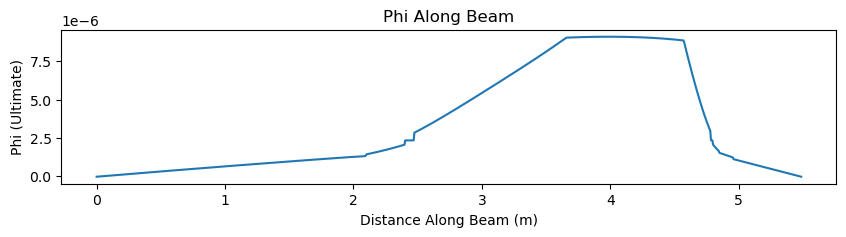

In [40]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(x,phi_ult)
ax.set_xlabel('Distance Along Beam (m)')
ax.set_ylabel('Phi (Ultimate)')
ax.set_title('Phi Along Beam')

In [41]:
seg_width = (l/num_segments)*1000 # mm

# Finding Trapezoidal Centroids and Areas
centroids = np.zeros(num_segments)
trap_area = np.zeros(num_segments)
for i in range(num_segments):
    centroids[i]=x[i]*1000+(seg_width*(2*M_ult[i]+M_ult[i+1])/(3*(M_ult[i]+M_ult[i+1])))
    trap_area[i]=seg_width*(max(phi_ult[i],phi_ult[i+1])-abs(phi_ult[i]-phi_ult[i+1])/2)
    
centroids = np.append(0,centroids)
trap_area = np.append(0,trap_area)

In [42]:
t_ba = np.zeros(len(x))

for i in tqdm(range(len(x)),desc='Progress'):
    for j in range(len(centroids)):
        if centroids[j]<x[i]*1000:
            t_ba[i]+=(x[i]*1000-centroids[j])*trap_area[j]

Progress: 100%|███████████████████████████| 1001/1001 [00:00<00:00, 1917.29it/s]


In [43]:
slope_ls = np.sum(trap_area*(l*1000-centroids))/(l*1000)
deflec = slope_ls*x*1000-t_ba

(-17.200005620793707, 0.0)

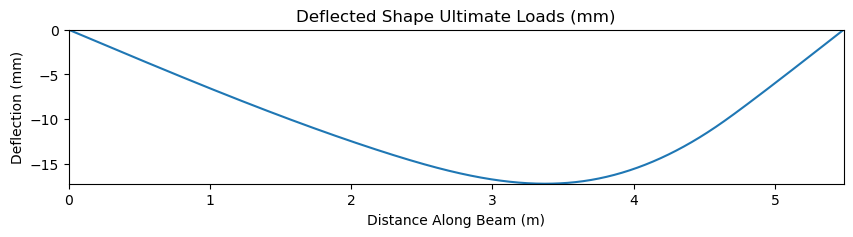

In [44]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(x,-deflec)
ax.set_xlabel('Distance Along Beam (m)')
ax.set_ylabel('Deflection (mm)')
ax.set_title('Deflected Shape Ultimate Loads (mm)')
ax.set_xlim(0,l)
ax.set_ylim(-max(deflec),0)

In [45]:
index = np.where(deflec==max(deflec))
x[index]

array([3.37413589])